# IOU

In [1]:
from shapely.geometry import box
import numpy as np
import supervision as sv

def yolo_to_absolute_bbox(yolo_bbox, img_size=416):
    """Convert YOLO format (normalized) bbox to absolute pixel coordinates."""
    _, x_center, y_center, width, height = yolo_bbox
    x_center, y_center, width, height = (
        x_center * img_size,
        y_center * img_size,
        width * img_size,
        height * img_size,
    )
    
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    
    return np.array([x_min, y_min, x_max, y_max])

def compute_iou_shapely(bbox1, bbox2, img_size=416):
    """Compute IoU using Shapely for two YOLO format bounding boxes."""
    # Convert YOLO format to absolute pixel coordinates
    x1_min, y1_min, x1_max, y1_max = yolo_to_absolute_bbox(bbox1, img_size)
    x2_min, y2_min, x2_max, y2_max = yolo_to_absolute_bbox(bbox2, img_size)

    # Create bounding box polygons
    box1 = box(x1_min, y1_min, x1_max, y1_max)
    box2 = box(x2_min, y2_min, x2_max, y2_max)

    # Compute intersection and union areas
    intersection_area = box1.intersection(box2).area
    union_area = box1.union(box2).area

    # Compute IoU
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

def compute_iou_supervision(bbox1, bbox2, img_size=416):
    """Compute IoU using supervision's box_iou_batch function."""
    box1 = yolo_to_absolute_bbox(bbox1, img_size).reshape(1, 4)
    box2 = yolo_to_absolute_bbox(bbox2, img_size).reshape(1, 4)

    iou_matrix = sv.box_iou_batch(box1, box2)  # Compute IoU
    return iou_matrix[0, 0]  # Extract IoU value

In [2]:
# Example YOLO bounding boxes (class_id, x_center, y_center, width, height)
bbox1 = [0, 0.5, 0.5, 0.2, 0.2]  # box1
bbox2 = [0, 0.55, 0.55, 0.2, 0.2] # box2

iou_shapely = compute_iou_shapely(bbox1, bbox2)
iou_supervision = compute_iou_supervision(bbox1, bbox2)

print(f"IoU (Shapely): {iou_shapely:.4f}")
print(f"IoU (Supervision): {iou_supervision:.4f}")

IoU (Shapely): 0.3913
IoU (Supervision): 0.3913


# AP50

Precision: [1.         0.5        0.66666667 0.75       0.8        0.66666667
 0.71428571 0.75       0.77777778 0.7        0.72727273 0.75
 0.76923077 0.78571429 0.8        0.8125     0.82352941 0.77777778
 0.78947368 0.75       0.71428571 0.72727273 0.73913043 0.70833333
 0.68       0.65384615 0.66666667 0.64285714 0.65517241 0.66666667
 0.67741935 0.6875     0.66666667 0.64705882 0.65714286 0.63888889
 0.64864865 0.65789474 0.66666667 0.675      0.68292683 0.66666667
 0.65116279 0.63636364 0.62222222 0.63043478 0.61702128 0.625
 0.6122449  0.6        0.60784314 0.61538462 0.60377358 0.61111111
 0.61818182 0.60714286 0.61403509 0.62068966 0.61016949 0.61666667
 0.62295082 0.62903226 0.61904762 0.625      0.63076923 0.63636364
 0.62686567 0.63235294 0.62318841 0.62857143 0.63380282 0.63888889
 0.63013699 0.62162162 0.61333333 0.60526316 0.5974026  0.6025641
 0.59493671 0.6        0.59259259 0.58536585 0.57831325 0.57142857
 0.56470588 0.55813953 0.55172414 0.55681818 0.5505618  0.54444

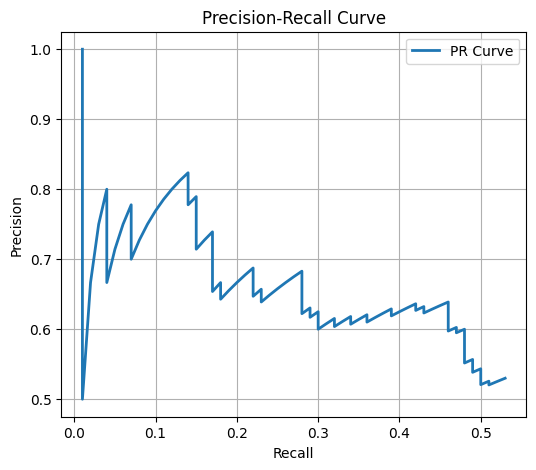

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# Function to compute IoU using Shapely
def compute_iou(box1, box2):
    """Compute IoU between two bounding boxes using Shapely."""
    box1 = box(*box1)
    box2 = box(*box2)
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union if union > 0 else 0.0

# Generate synthetic data: ground truth & predicted boxes with confidence scores
def generate_boxes(num_images=10, img_size=100, box_size=20):
    """Generate random ground truth and predicted boxes along with confidence scores."""
    gt_boxes = []
    pred_boxes = []
    conf_scores = []

    for _ in range(num_images):
        gt = []
        pred = []
        conf = []
        for _ in range(10):  # 10 objects per image
            # Random ground truth box
            x_gt = np.random.randint(0, img_size - box_size)
            y_gt = np.random.randint(0, img_size - box_size)
            gt.append((x_gt, y_gt, x_gt + box_size, y_gt + box_size))

            # Random predicted box with confidence score
            x_pred = np.random.randint(0, img_size - box_size)
            y_pred = np.random.randint(0, img_size - box_size)
            pred.append((x_pred, y_pred, x_pred + box_size, y_pred + box_size))
            conf.append(np.random.uniform(0.5, 1.0))  # Random confidence score

        gt_boxes.append(gt)
        pred_boxes.append(pred)
        conf_scores.append(conf)

    return gt_boxes, pred_boxes, conf_scores

# Compute Precision-Recall (PR) curve at IoU threshold
def compute_precision_recall(gt_boxes, pred_boxes, conf_scores, iou_threshold=0.5):
    """Compute precision-recall curve at a given IoU threshold."""
    all_pred_boxes = [box for img in pred_boxes for box in img]
    all_gt_boxes = [box for img in gt_boxes for box in img]
    all_conf_scores = np.array([score for img in conf_scores for score in img])

    # Sort predictions by confidence score (high → low)
    sorted_indices = np.argsort(-all_conf_scores)
    sorted_pred_boxes = [all_pred_boxes[i] for i in sorted_indices]

    tp = np.zeros(len(sorted_pred_boxes))
    fp = np.zeros(len(sorted_pred_boxes))
    matched_gt = set()

    for i, pred in enumerate(sorted_pred_boxes):
        ious = [compute_iou(pred, gt) for gt in all_gt_boxes]
        best_iou = max(ious) if ious else 0
        best_match = np.argmax(ious) if ious else -1

        if best_iou >= iou_threshold and best_match not in matched_gt:
            tp[i] = 1  # True Positive
            matched_gt.add(best_match)
        else:
            fp[i] = 1  # False Positive

    # Compute cumulative precision and recall
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    recall = cum_tp / len(all_gt_boxes)
    precision = cum_tp / (cum_tp + cum_fp)

    return precision, recall

# Run Experiment
gt_boxes, pred_boxes, conf_scores = generate_boxes()
precision, recall = compute_precision_recall(gt_boxes, pred_boxes, conf_scores)

# Print precision and recall values
print("Precision:", precision)
print("Recall:", recall)

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="PR Curve", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

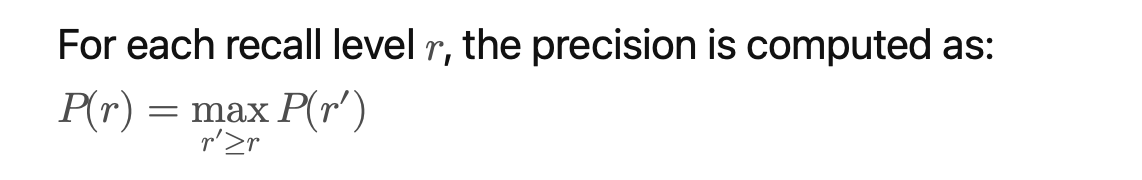

* For Pascal VOC 11 point interpolation method: use r as linspace(0,1,11)
* For COCO 101-point interpolation method: use r as linspace(0,1,101)
* For Area under Precision-Recall Curve (AP) method: calculate area under the curve of p-r curve.

In [4]:
from sklearn.metrics import auc

# AP using Pascal VOC 11-point interpolation
def compute_ap_voc(precision, recall):
    """Compute Average Precision using Pascal VOC 11-point interpolation."""
    recall_levels = np.linspace(0, 1, 11)  # [0.0, 0.1, ..., 1.0]
    ap = 0.0

    for r in recall_levels:
        prec_at_r = precision[recall >= r].max() if np.any(recall >= r) else 0
        ap += prec_at_r

    return ap / 11  # Average over 11 recall levels

# AP using COCO 101-point interpolation
def compute_ap_coco(precision, recall):
    """Compute Average Precision using COCO 101-point interpolation."""
    recall_levels = np.linspace(0, 1, 101)  # [0.00, 0.01, ..., 1.00]
    ap = np.mean([precision[recall >= r].max() if np.any(recall >= r) else 0 for r in recall_levels])
    return ap

# AP using Area Under Precision-Recall Curve
def compute_ap_auc(precision, recall):
    """Compute Average Precision using AUC of PR curve."""
    return auc(recall, precision)



In [ ]:
# Compute AP using different methods
ap_voc = compute_ap_voc(precision, recall)
ap_coco = compute_ap_coco(precision, recall)
ap_auc = compute_ap_auc(precision, recall)

# Print results
print(f"AP50 (VOC 11-point): {ap_voc:.4f}")
print(f"AP50 (COCO 101-point): {ap_coco:.4f}")
print(f"AP50 (AUC-based): {ap_auc:.4f}")

AP50 (VOC 11-point): 0.3815
AP50 (COCO 101-point): 0.3385
AP50 (AUC-based): 0.3011
